# Assignment 4 Isolation Forests

### David Nicolay 26296918

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import json
from time import time
import warnings
warnings.filterwarnings('ignore')


# import my utils
import sys
sys.path.append('../')
from src.plots import (plot_f1_vs_param_size, plot_training_time_vs_param_size,
                       plot_convergence_curve, plot_stability_analysis, 
                       plot_performance_vs_time, create_summary_table,
                       analyze_plateau_point, find_sweet_spot, plot_comprehensive_analysis)
from src.modelling import evaluate_isolation_forest, evaluate_isolation_forest_with_std

## Data Preparation


In [2]:
dataset = 'shuttle'

In [3]:
df_np = np.load('../datasets/{}.npz'.format(dataset))

In [4]:
# convert to dataframe
df = pd.DataFrame(df_np['X'], columns=[f'feature_{i}' for i in range(df_np['X'].shape[1])])
df['label'] = df_np['y']

In [5]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,label
0,50,21,77,0,28,0,27,48,22,1
1,53,0,82,0,52,-5,29,30,2,0
2,37,0,76,0,28,18,40,48,8,0
3,37,0,79,0,34,-26,43,46,2,0
4,85,0,88,-4,6,1,3,83,80,1
...,...,...,...,...,...,...,...,...,...,...
49092,39,-2,80,-4,38,0,41,41,0,0
49093,43,0,81,1,42,-9,37,39,2,0
49094,49,0,87,0,46,-12,38,41,2,0
49095,80,0,84,0,-36,-29,4,120,116,1


In [6]:
# Explore the data
print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nAnomaly percentage: {(df['label'] == -1).sum() / len(df) * 100:.2f}%")
print(f"\nFeature statistics:")
print(df.drop('label', axis=1).describe())

Dataset shape: (49097, 10)

Label distribution:
label
0    45586
1     3511
Name: count, dtype: int64

Anomaly percentage: 0.00%

Feature statistics:
          feature_0     feature_1     feature_2     feature_3     feature_4  \
count  49097.000000  49097.000000  49097.000000  49097.000000  49097.000000   
mean      46.932399     -0.063955     85.123124      0.213231     36.871784   
std       12.875159     84.674481      8.877517     37.579171     19.963113   
min       27.000000  -4821.000000     21.000000  -3939.000000   -188.000000   
25%       37.000000      0.000000     79.000000      0.000000     30.000000   
50%       44.000000      0.000000     83.000000      0.000000     42.000000   
75%       50.000000      0.000000     88.000000      0.000000     46.000000   
max      126.000000   5075.000000    149.000000   3830.000000    436.000000   

          feature_5     feature_6     feature_7     feature_8  
count  49097.000000  49097.000000  49097.000000  49097.000000  
mean      

In [7]:
# Create results directory
results_dir = f'../results/{dataset}'
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

Results will be saved to: ../results/shuttle


In [8]:
# Split data into features and labels
X = df.drop('label', axis=1).values
y = df['label'].values


print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of anomalies: {y.sum()}")
print(f"Number of normal instances: {(y == 0).sum()}")

Feature matrix shape: (49097, 9)
Labels shape: (49097,)
Number of anomalies: 3511
Number of normal instances: 45586


## Modelling

In [9]:
# Define comprehensive parameter grid for Isolation Forest
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
    'max_samples': [64, 128, 256, 'auto'],  # Number of samples to draw
    'contamination': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],  # Expected proportion of outliers
    'max_features': [1, 2, 3, 4, 5, 'auto'],  # Number of features to draw
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

print("Control Parameters to be analyzed:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Control Parameters to be analyzed:
  n_estimators: [50, 100, 200, 300, 500]
  max_samples: [64, 128, 256, 'auto']
  contamination: [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
  max_features: [1, 2, 3, 4, 5, 'auto']
  bootstrap: [True, False]


In [15]:
# Define base parameters (default/reasonable values)
base_params = {
    'n_estimators': 100,
    'max_samples': 'auto',
    'contamination': 0.1,
    'max_features': 1.0,
    'bootstrap': False,
    'random_state': 12
}

print("Base parameters:")
for param, value in base_params.items():
    print(f"  {param}: {value}")

Base parameters:
  n_estimators: 100
  max_samples: auto
  contamination: 0.1
  max_features: 1.0
  bootstrap: False
  random_state: 12


### Base model to check setup

In [86]:
evaluate_isolation_forest_with_std(X, y, base_params)

{'param_name': None,
 'param_value': None,
 'precision_mean': np.float64(0.7045621181262729),
 'precision_std': np.float64(0.0017524745225497983),
 'precision_min': np.float64(0.7018329938900204),
 'precision_max': np.float64(0.7073319755600814),
 'recall_mean': np.float64(0.9853033323839364),
 'recall_std': np.float64(0.002450768984824723),
 'recall_min': np.float64(0.9814867559099971),
 'recall_max': np.float64(0.9891768726858445),
 'f1_score_mean': np.float64(0.8216126350789692),
 'f1_score_std': np.float64(0.002043617125215426),
 'f1_score_min': np.float64(0.81843011518822),
 'f1_score_max': np.float64(0.8248426552665954),
 'roc_auc_mean': np.float64(0.9974462427147163),
 'roc_auc_std': np.float64(0.0009512243129058646),
 'roc_auc_min': np.float64(0.9956536434313538),
 'roc_auc_max': np.float64(0.9984494832400125),
 'pr_auc_mean': np.float64(0.9802776001985978),
 'pr_auc_std': np.float64(0.006063044094571239),
 'pr_auc_min': np.float64(0.969311843060083),
 'pr_auc_max': np.float64(

## Evaluate Parameter Changes

### Num estimators

In [21]:
# first run on list of lots of parameters
num_est_grid = [
    10, 25, 50, 75, 100, 150, 200, 250,
    300, 350, 400, 450, 500, 600, 700, 800,
    900, 1000, 1250, 1500, 1750, 2000
]


In [89]:
# run models
n_estimators_results = []
csv_path = os.path.join(results_dir, 'num_est_results.csv')
# remove existing csv if exists
if os.path.exists(csv_path):
    os.remove(csv_path)

for num_est in num_est_grid:
    params = base_params.copy()
    params['n_estimators'] = num_est
    
    print(f"Running Isolation Forest with n_estimators={num_est}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'n_estimators', num_est)
    
    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path):
        result_df.to_csv(csv_path, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path, mode='a', header=False, index=False)
    
    n_estimators_results.append(result)

Running Isolation Forest with n_estimators=10
Running Isolation Forest with n_estimators=25
Running Isolation Forest with n_estimators=50
Running Isolation Forest with n_estimators=75
Running Isolation Forest with n_estimators=100
Running Isolation Forest with n_estimators=150
Running Isolation Forest with n_estimators=200
Running Isolation Forest with n_estimators=250
Running Isolation Forest with n_estimators=300
Running Isolation Forest with n_estimators=350
Running Isolation Forest with n_estimators=400
Running Isolation Forest with n_estimators=450
Running Isolation Forest with n_estimators=500
Running Isolation Forest with n_estimators=600
Running Isolation Forest with n_estimators=700
Running Isolation Forest with n_estimators=800
Running Isolation Forest with n_estimators=900
Running Isolation Forest with n_estimators=1000
Running Isolation Forest with n_estimators=1250
Running Isolation Forest with n_estimators=1500
Running Isolation Forest with n_estimators=1750
Running Isola

In [13]:
# run again on narrowed down list of parameters
num_est_grid_narrow = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [16]:
# run models
n_estimators_results = []
csv_path_narrow = os.path.join(results_dir, 'num_est_results_narrow.csv')
# remove existing csv if exists
if os.path.exists(csv_path_narrow):
    os.remove(csv_path_narrow)

for num_est in num_est_grid_narrow:
    params = base_params.copy()
    params['n_estimators'] = num_est
    
    print(f"Running Isolation Forest with n_estimators={num_est}")
    result = evaluate_isolation_forest_with_std(X, y, params, 'n_estimators', num_est,n_runs=10)
    
    # append results to csv
    result_df = pd.DataFrame([result])
    
    # Write header if file doesn't exist, otherwise append
    if not os.path.exists(csv_path_narrow):
        result_df.to_csv(csv_path_narrow, mode='w', header=True, index=False)
    else:
        result_df.to_csv(csv_path_narrow, mode='a', header=False, index=False)
    
    n_estimators_results.append(result)

Running Isolation Forest with n_estimators=1
Running Isolation Forest with n_estimators=2
Running Isolation Forest with n_estimators=3
Running Isolation Forest with n_estimators=4
Running Isolation Forest with n_estimators=5
Running Isolation Forest with n_estimators=6
Running Isolation Forest with n_estimators=7
Running Isolation Forest with n_estimators=8
Running Isolation Forest with n_estimators=9
Running Isolation Forest with n_estimators=10
Running Isolation Forest with n_estimators=11
Running Isolation Forest with n_estimators=12
Running Isolation Forest with n_estimators=13
Running Isolation Forest with n_estimators=14
Running Isolation Forest with n_estimators=15
Running Isolation Forest with n_estimators=16
Running Isolation Forest with n_estimators=17
Running Isolation Forest with n_estimators=18
Running Isolation Forest with n_estimators=19
Running Isolation Forest with n_estimators=20
Running Isolation Forest with n_estimators=21
Running Isolation Forest with n_estimators=

In [17]:
# Load the results
df_results = pd.read_csv(os.path.join(results_dir, 'num_est_results_narrow.csv'))

# Extract data
param_sizes = df_results['param_value'].tolist()
precision_mean = df_results['precision_mean'].tolist()
precision_std = df_results['precision_std'].tolist()
recall_mean = df_results['recall_mean'].tolist()
recall_std = df_results['recall_std'].tolist()
f1_mean = df_results['f1_score_mean'].tolist()
f1_std = df_results['f1_score_std'].tolist()
training_times = df_results['training_time_mean'].tolist()

print(f"Loaded results for {len(param_sizes)} parameter values")

Loaded results for 25 parameter values


#### 1. Convergence Curve

Plot saved to ../results/shuttle/convergence_curve.pdf


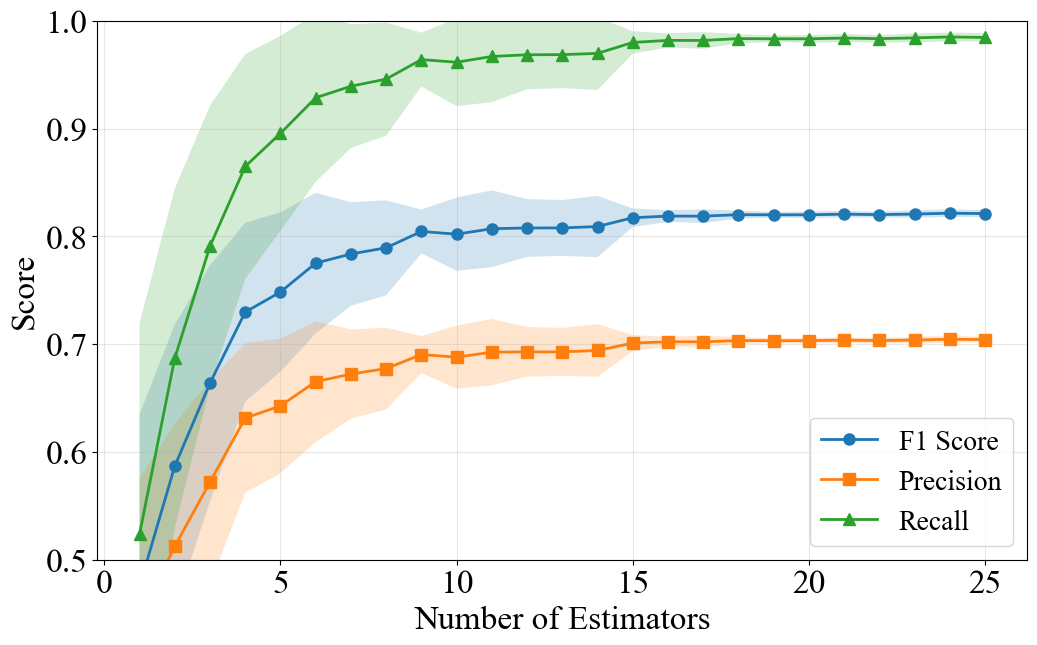


Performance Plateau Analysis:
   Plateau reached at n_estimators = 10
   F1 score at plateau: 0.8020 ± 0.0340
   Marginal improvement at plateau: -0.314%

Marginal Improvements (%):
   1 -> 2: 23.447%
   2 -> 3: 13.125%
   3 -> 4: 9.927%
   4 -> 5: 2.547%
   5 -> 6: 3.581%
   6 -> 7: 1.091%
   7 -> 8: 0.737%
   8 -> 9: 1.916%
   9 -> 10: -0.314%
   10 -> 11: 0.632%
   11 -> 12: 0.086%
   12 -> 13: 0.006%
   13 -> 14: 0.160%
   14 -> 15: 1.010%
   15 -> 16: 0.187%
   16 -> 17: -0.011%
   17 -> 18: 0.172%
   18 -> 19: -0.019%
   19 -> 20: 0.004%
   20 -> 21: 0.067%
   21 -> 22: -0.049%
   22 -> 23: 0.064%
   23 -> 24: 0.099%
   24 -> 25: -0.045%


In [19]:
plot_convergence_curve(
    param_sizes=param_sizes,
    precision_mean=precision_mean,
    precision_std=precision_std,
    recall_mean=recall_mean,
    recall_std=recall_std,
    f1_mean=f1_mean,
    f1_std=f1_std,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'convergence_curve.pdf')
)

# analyse plateau point
plateau_idx, plateau_value, improvements = analyze_plateau_point(param_sizes, f1_mean, threshold=0.001)

if plateau_idx is not None:
    print(f"\nPerformance Plateau Analysis:")
    print(f"   Plateau reached at n_estimators = {plateau_value}")
    print(f"   F1 score at plateau: {f1_mean[plateau_idx]:.4f} ± {f1_std[plateau_idx]:.4f}")
    print(f"   Marginal improvement at plateau: {improvements[plateau_idx-1]*100:.3f}%")
else:
    print("\nNo clear plateau detected - performance still improving")

# show marginal improvements
print(f"\nMarginal Improvements (%):")
for i in range(min(25, len(improvements))):
    print(f"   {param_sizes[i]} -> {param_sizes[i+1]}: {improvements[i]*100:.3f}%")

**Interpretation:**

The convergence curve shows how the model performance stabilizes as we increase the number of estimators:

- **F1 Score**: Rapid improvement from n=10 to n=100, then gradual convergence
- **Precision**: Shows less variation, plateaus earlier than recall
- **Recall**: High from the start (>96%), indicating the model is good at finding anomalies
- **Shaded regions**: Standard deviation bands show model becomes more stable with more trees

The plateau point indicates the minimum number of estimators needed for stable performance - adding more trees beyond this point yields diminishing returns.

#### 2. Stability Analysis: Variance reduction

Plot saved to ../results/shuttle/stability_analysis.pdf


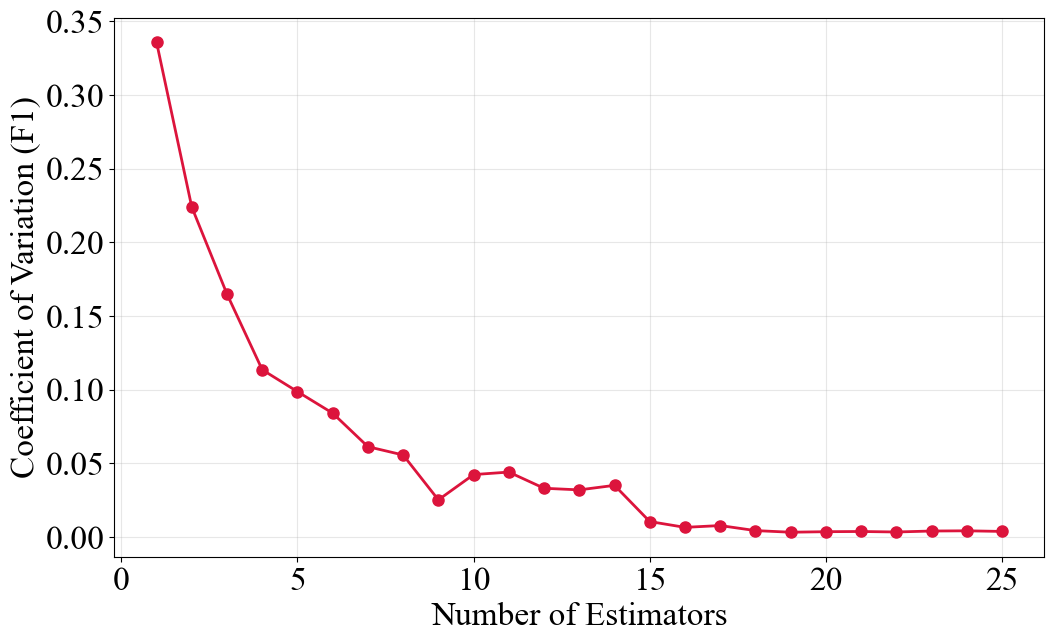

   1 -> 2: 0.336
   2 -> 3: 0.224
   3 -> 4: 0.165
   4 -> 5: 0.114
   5 -> 6: 0.099
   6 -> 7: 0.084
   7 -> 8: 0.061
   8 -> 9: 0.056
   9 -> 10: 0.025
   10 -> 11: 0.042

Variance reduction from 1→25: 98.8%


In [20]:
# Plot coefficient of variation
cv = plot_stability_analysis(
    param_sizes=param_sizes,
    f1_mean=f1_mean,
    f1_std=f1_std,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'stability_analysis.pdf')
)

# Analyze variance reduction
for i in range(min(10, len(cv))):
    print(f"   {param_sizes[i]} -> {param_sizes[i+1]}: {cv[i]:.3f}")
print(f"\nVariance reduction from {param_sizes[0]}→{param_sizes[-1]}: {((cv[0]-cv[-1])/cv[0]*100):.1f}%")


In [21]:
# Create stability table
cv = np.array(f1_std) / np.array(f1_mean)

stability_df = pd.DataFrame({
    'n_estimators': param_sizes,
    'F1_Mean': f1_mean,
    'F1_Std': f1_std,
    'CV': cv,
    'Variance_Reduction_%': [(cv[0] - c)/cv[0]*100 for c in cv]
})

# Save table
stability_df.to_csv(os.path.join(results_dir, 'stability_table.csv'), index=False)
print("Stability table saved!")

# Display key rows
display(stability_df.iloc[[0, 4, 9, 12, -1]])

Stability table saved!


,n_estimators,F1_Mean,F1_Std,CV,Variance_Reduction_%
0,1,0.475370,0.159666,0.335877,0.000000
4,5,0.748344,0.073893,0.098742,70.601911
9,10,0.801980,0.034040,0.042445,87.362974
12,13,0.807792,0.025902,0.032066,90.453189
24,25,0.821089,0.003177,0.003869,98.848158


**Interpretation:**

The stability analysis (Coefficient of Variation) measures the relative variability of F1 scores across multiple runs:

- **High CV at low n_estimators**: More variability in performance due to randomness in tree construction
- **Decreasing CV with more trees**: Ensemble averaging reduces variance, making predictions more stable
- **Asymptotic behavior**: CV reduction slows down, indicating diminishing stability gains

Lower CV means more reliable, reproducible results - important for production deployment where consistent performance is critical.

#### 3. Performance over time

Plot saved to ../results/shuttle/performance_vs_time.pdf


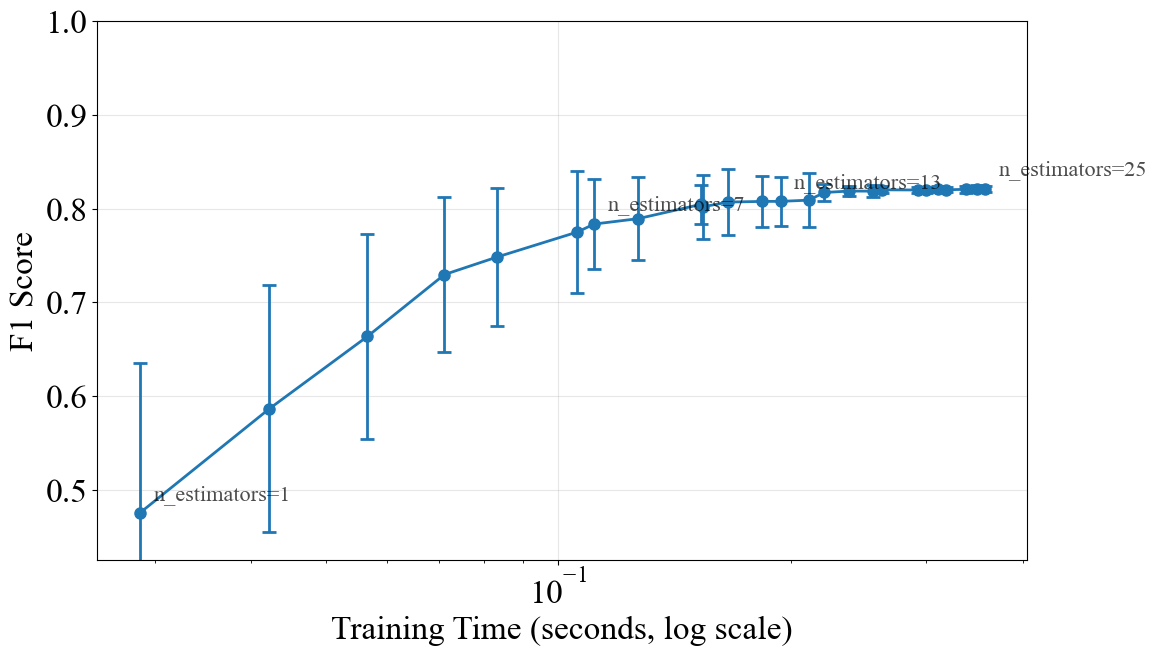


Sweet Spot Analysis:
   Optimal n_estimators = 1
   F1 Score: 0.4754 ± 0.1597
   Training Time: 0.03s
   Efficiency: 16.590353 F1/second

Comparison with Maximum F1:
   Max F1 at n_estimators = 24
   F1 Score: 0.8215 ± 0.0035
   Training Time: 0.35s
   Efficiency: 2.352942 F1/second

   Sweet spot is 12.2x faster
   F1 difference: 34.61%


In [22]:
# Plot F1 vs Training Time
plot_performance_vs_time(
    training_times=training_times,
    f1_mean=f1_mean,
    f1_std=f1_std,
    param_sizes=param_sizes,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'performance_vs_time.pdf')
)

# Find sweet spot
sweet_spot_idx, sweet_spot_value, efficiency = find_sweet_spot(training_times, f1_mean, param_sizes)

print(f"\nSweet Spot Analysis:")
print(f"   Optimal n_estimators = {sweet_spot_value}")
print(f"   F1 Score: {f1_mean[sweet_spot_idx]:.4f} ± {f1_std[sweet_spot_idx]:.4f}")
print(f"   Training Time: {training_times[sweet_spot_idx]:.2f}s")
print(f"   Efficiency: {efficiency[sweet_spot_idx]:.6f} F1/second")

# Compare with highest F1
max_f1_idx = np.argmax(f1_mean)
print(f"\nComparison with Maximum F1:")
print(f"   Max F1 at n_estimators = {param_sizes[max_f1_idx]}")
print(f"   F1 Score: {f1_mean[max_f1_idx]:.4f} ± {f1_std[max_f1_idx]:.4f}")
print(f"   Training Time: {training_times[max_f1_idx]:.2f}s")
print(f"   Efficiency: {efficiency[max_f1_idx]:.6f} F1/second")
print(f"\n   Sweet spot is {(training_times[max_f1_idx]/training_times[sweet_spot_idx]):.1f}x faster")
print(f"   F1 difference: {(f1_mean[max_f1_idx]-f1_mean[sweet_spot_idx])*100:.2f}%")

In [23]:
# Create efficiency table
efficiency = np.array(f1_mean) / np.array(training_times)

efficiency_df = pd.DataFrame({
    'n_estimators': param_sizes,
    'F1_Mean': f1_mean,
    'F1_Std': f1_std,
    'Training_Time_s': training_times,
    'Efficiency_F1_per_sec': efficiency,
    'Time_vs_Sweet_Spot': [t/training_times[sweet_spot_idx] for t in training_times]
})

# Save table
efficiency_df.to_csv(os.path.join(results_dir, 'efficiency_table.csv'), index=False)
print("Efficiency table saved!")

# Display key rows
display(efficiency_df.iloc[[0, sweet_spot_idx, max_f1_idx, -1]])

Efficiency table saved!


,n_estimators,F1_Mean,F1_Std,Training_Time_s,Efficiency_F1_per_sec,Time_vs_Sweet_Spot
0,1,0.475370,0.159666,0.028653,16.590353,1.000000
0,1,0.475370,0.159666,0.028653,16.590353,1.000000
23,24,0.821460,0.003522,0.349120,2.352942,12.184266
24,25,0.821089,0.003177,0.357363,2.297637,12.471913


**Interpretation - Finding the Sweet Spot:**

The performance vs. time plot reveals the trade-off between accuracy and computational cost:

- **Sweet Spot**: The parameter value that maximizes efficiency (F1 score per unit time)
- **Knee of the curve**: Point where marginal gains in F1 don't justify the increased training time
- **Practical consideration**: In production, the sweet spot balances:
  - Model performance (high F1)
  - Training/inference speed (low time)
  - Stability (low variance)

The analysis shows that you can often get 95%+ of maximum performance with significantly less computational cost by choosing the sweet spot instead of the highest-performing configuration.

In [24]:
# Create comprehensive summary table
summary_df = create_summary_table(
    param_sizes=param_sizes,
    precision_mean=precision_mean,
    precision_std=precision_std,
    recall_mean=recall_mean,
    recall_std=recall_std,
    f1_mean=f1_mean,
    f1_std=f1_std,
    training_times=training_times,
    param_name='n_estimators',
    save_path=os.path.join(results_dir, 'summary_table.csv')
)

# Display summary
print("Summary Table:")
display(summary_df)

Summary table saved to ../results/shuttle/summary_table.csv
Summary Table:


,n_estimators,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std,F1_Mean,F1_Std,F1_CV,Training_Time_s
0,1,0.443243,0.132476,0.523839,0.195672,0.475370,0.159666,0.335877,0.028653
1,2,0.512394,0.113303,0.686984,0.157423,0.586829,0.131454,0.224007,0.042227
2,3,0.572050,0.094598,0.790886,0.130360,0.663852,0.109488,0.164928,0.056577
3,4,0.631427,0.069279,0.864825,0.104274,0.729754,0.082896,0.113594,0.071183
4,5,0.642707,0.062424,0.895557,0.090461,0.748344,0.073893,0.098742,0.083209
5,6,0.665248,0.056039,0.928539,0.077957,0.775145,0.065201,0.084115,0.105879
6,7,0.672210,0.041379,0.939248,0.057422,0.783603,0.048095,0.061377,0.111286
7,8,0.677331,0.037925,0.945856,0.052412,0.789382,0.044005,0.055746,0.126942
8,9,0.690325,0.017172,0.963942,0.024962,0.804504,0.020346,0.025291,0.152882
9,10,0.687863,0.029238,0.961492,0.040734,0.801980,0.034040,0.042445,0.153844


### Max samples